In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from lmfit import Model

In [40]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

c6 = ['#c4bae2','#40ada6','#3c4ebf',
        '#e3a600', '#d6543a', '#edb1a3']
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,4]]
hue_order = ['Rand. Proj.', 'PCA', 'SCVI', 'Geneformer']


def rename_nicely(df):
    df.replace('celltype.l3', 'Cell type MI', inplace=True)
    df.replace('protein_counts', 'Protein MI', inplace=True)
    df.replace('clone', 'Clonal MI', inplace=True)
    df.replace('author_day', 'Developmental MI', inplace=True)
    df.replace('ng_idx', 'Spatial MI', inplace=True)
    df.replace('RandomProjection', 'Rand. Proj.', inplace=True)

In [43]:
res_df = pd.read_csv('collect_mi_results.csv')
res_df = res_df[res_df['signal'] == 'author_day']
res_df = res_df[res_df['size'] == 10**7]
rename_nicely(res_df)

/tmp/ipykernel_1726362/1576597464.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


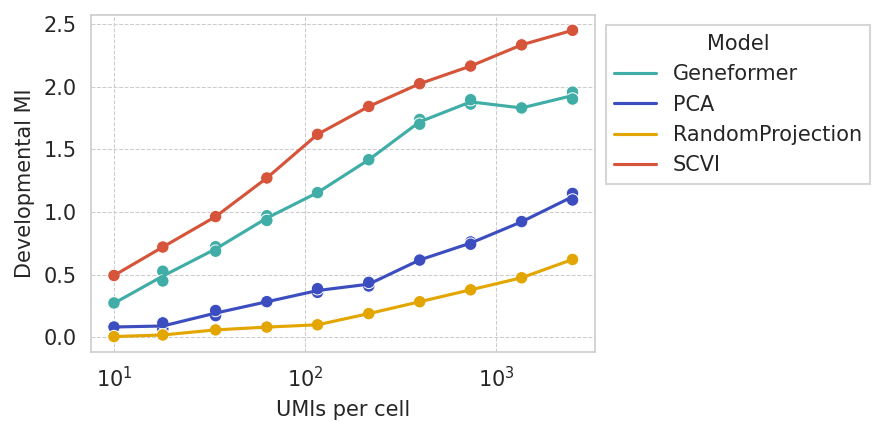

In [5]:
fig = plt.figure(figsize=(6,3))

sns.lineplot(
    data=res_df,
    x="umis_per_cell",
    y="mi_value",
    hue="algorithm",
    # marker="o",
    ci=None,
    palette=pretty_palette,
)

# overlay the raw points
sns.scatterplot(
    data=res_df,
    x="umis_per_cell",
    y="mi_value",
    hue="algorithm",
    legend=False,
    palette=pretty_palette,
)

plt.xlabel("UMIs per cell")
plt.ylabel("Developmental MI")

plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))

plt.xscale("log")
plt.tight_layout()
plt.show()

In [51]:
noise_df = pd.read_csv('analysis/final_results/scaling_plots_u_bar_138.109_I_max_1.419.csv')
noise_df = noise_df[noise_df['I_max_error'] < 0.5]
noise_df = noise_df[noise_df['metric'] == 'author_day']
rename_nicely(noise_df)

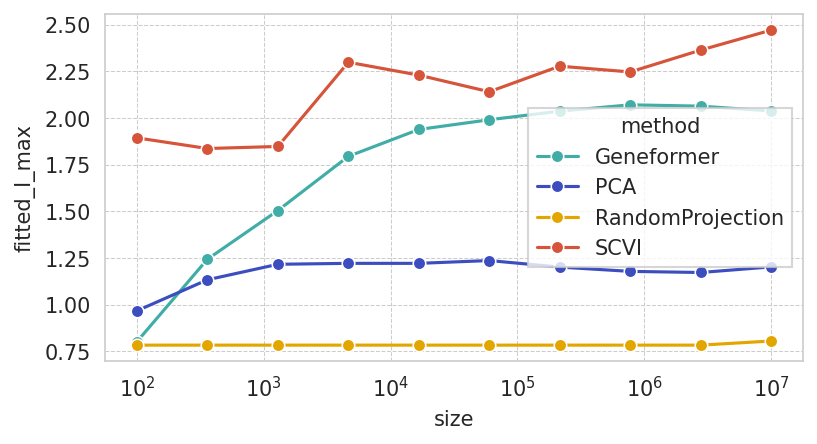

In [10]:
fig = plt.figure(figsize=(6,3))

sns.lineplot(
    data=noise_df,
    x="size",
    y="fitted_I_max",
    hue="method",
    marker="o",
    errorbar=None,
    palette=pretty_palette,
)
plt.xscale('log')

In [38]:
def cell_number_scaling(x, N0, s, I_inf):
    """
    Cell number scaling function: I(x) = max(I_0, I_inf - (x / N0) ** (-s))
    """
    I_0 = 0
    with np.errstate(divide="ignore", invalid="ignore", over="ignore"):
        # Calculate the scaling term more safely to avoid overflow
        ratio = x / N0
        # Use log-space calculation to avoid overflow
        scaling_term = np.where(
            ratio > 0,
            np.exp(-s * np.log(ratio)),
            0.0
        )
        result = np.where(x > 0, np.maximum(I_0, I_inf - scaling_term), np.nan)
    return result

def info_scaling(u, u_bar, I_max):
    """
    Information scaling function based on:
        I(u) = I_max - 0.5 * log2( (1 + u/u_bar) / (u/u_bar + 2**(-2*I_max)) )
    """
    # Avoid division by zero and invalid values
    u = np.asarray(u)
    u_bar = np.asarray(u_bar)
    I_max = np.asarray(I_max)
    # Set a small epsilon to avoid division by zero
    epsilon = 1e-12
    u_bar_safe = np.where(u_bar == 0, epsilon, u_bar)
    u_over_u_bar = u / u_bar_safe
    numerator = 1 + u_over_u_bar
    denominator = u_over_u_bar + 2 ** (-2 * I_max)
    # Avoid division by zero in denominator
    denominator = np.where(denominator == 0, epsilon, denominator)
    # Avoid negative or zero values inside log2
    ratio = numerator / denominator
    ratio = np.where(ratio <= 0, epsilon, ratio)
    return I_max - 0.5 * np.log2(ratio)

Method: Geneformer
[[Model]]
    Model(cell_number_scaling)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 10
    # variables        = 3
    chi-square         = 0.01171734
    reduced chi-square = 0.00167391
    Akaike info crit   = -61.4927037
    Bayesian info crit = -60.5849484
    R-squared          = 0.99300720
[[Variables]]
    N0:     226.012115 +/- 26.7528535 (11.84%) (init = 100)
    s:      0.35011389 +/- 0.02895158 (8.27%) (init = 0.5)
    I_inf:  2.11208180 +/- 0.02916492 (1.38%) (init = 2.07)
[[Correlations]] (unreported correlations are < 0.100)
    C(N0, I_inf) = +0.8206
    C(s, I_inf)  = -0.8039
    C(N0, s)     = -0.6434
Method: PCA
[[Model]]
    Model(cell_number_scaling)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 10
    # variables        = 3
    chi-square         = 0.00427736
    reduced chi-square = 6.1105e-04
    Akaike info crit   = -71.57003

(0.0, 3.0)

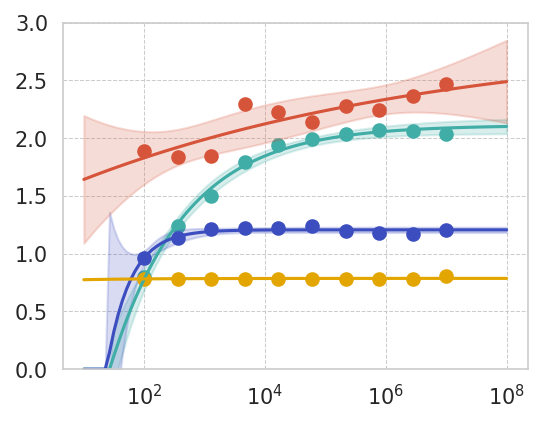

In [37]:
fig, axs = plt.subplots()


for i, method in enumerate(noise_df['method'].unique()):
    sub_df = noise_df[noise_df['method'] == method]

    x_data = sub_df['size']
    y_data = sub_df['fitted_I_max']

    model = Model(cell_number_scaling)
    params = model.make_params(N0=1e2, s=0.5, I_inf=y_data.max())
    params['N0'].min = 0
    params['N0'].max = x_data.max()
    params['I_inf'].min = 0
    # params['I_0'].min = 0
    params['s'].min = 0
    result = model.fit(y_data, params, x=x_data)
    print(f"Method: {method}")
    print(result.fit_report())
    
    x_fit = np.logspace(np.log10(x_data.min()/10), np.log10(x_data.max()*10), 100)
    y_fit = result.eval(params=result.params, x=x_fit)
    axs.plot(x_fit, y_fit, label=f"{method} fit", color=pretty_palette[i])

    axs.scatter(x_data, y_data, label=f"{method} data", color=pretty_palette[i])

    # confidence bands
    y_upper = result.eval_uncertainty(params=result.params,
                                    x=x_fit, sigma=2)
    y_lower = -y_upper
    if y_upper.max() < 2:
        axs.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower,
                        color=pretty_palette[i], alpha=0.2)

plt.xscale('log')
plt.ylim(0, 3)

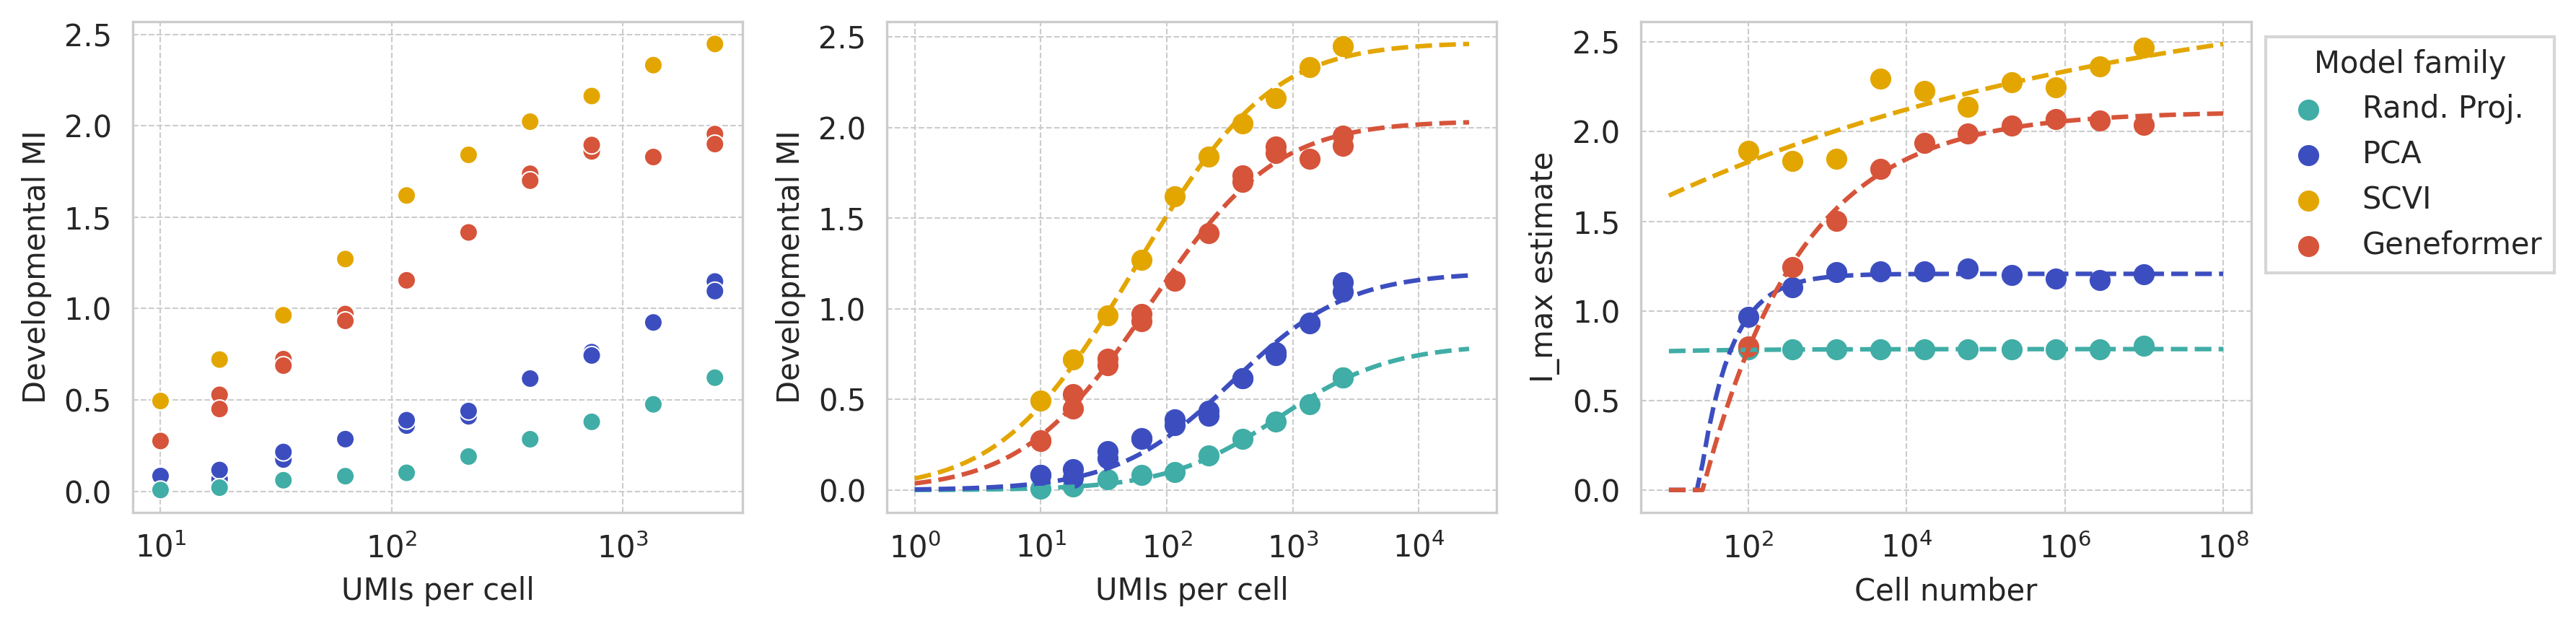

In [83]:
# three subplots: left raw data, middle noise scaling, right cell scaling, share y axis

fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=False, dpi=300)

sns.scatterplot(
    data=res_df,
    x="umis_per_cell",
    y="mi_value",
    hue="algorithm",
    legend=False,
    palette=pretty_palette,
    hue_order=hue_order,
    ax=axs[0],
)

axs[0].set_xlabel("UMIs per cell")
axs[0].set_ylabel("Developmental MI")
# axs[0].legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
axs[0].set_xscale("log")

# now fits

for i, method in enumerate(hue_order):
    sub_df = res_df[res_df['algorithm'] == method]

    x_data = sub_df['umis_per_cell']
    y_data = sub_df['mi_value']

    Imax = noise_df[noise_df['method'] == method]['fitted_I_max'].values[-1]
    u_bar = noise_df[noise_df['method'] == method]['fitted_u_bar'].values[-1]

    x_fit = np.logspace(np.log10(x_data.min()/10), np.log10(x_data.max()*10), 100)
    y_fit = info_scaling(x_fit, u_bar, Imax)

    axs[1].plot(x_fit, y_fit, label=f"{method} fit", color=pretty_palette[i], linestyle='--')
    axs[1].scatter(x_data, y_data, label=f"{method} data", color=pretty_palette[i])

axs[1].set_xlabel("UMIs per cell")
axs[1].set_xscale("log")
axs[1].set_ylabel("Developmental MI")

for i, method in enumerate(hue_order):
    sub_df = noise_df[noise_df['method'] == method]

    x_data = sub_df['size']
    y_data = sub_df['fitted_I_max']

    model = Model(cell_number_scaling)
    params = model.make_params(N0=1e2, s=0.5, I_inf=y_data.max())
    params['N0'].min = 0
    params['N0'].max = x_data.max()
    params['I_inf'].min = 0
    # params['I_0'].min = 0
    params['s'].min = 0
    result = model.fit(y_data, params, x=x_data)
    # print(f"Method: {method}")
    # print(result.fit_report())
    
    x_fit = np.logspace(np.log10(x_data.min()/10), np.log10(x_data.max()*10), 100)
    y_fit = result.eval(params=result.params, x=x_fit)
    axs[2].plot(x_fit, y_fit, color=pretty_palette[i], linestyle='--')

    axs[2].scatter(x_data, y_data, label=f"{method}", color=pretty_palette[i])

    # confidence bands
    # y_upper = result.eval_uncertainty(params=result.params,
    #                                 x=x_fit, sigma=2)
    # y_lower = -y_upper
    # if y_upper.max() < 2:
    #     axs[2].fill_between(x_fit, y_fit + y_upper, y_fit + y_lower,
    #                     color=pretty_palette[i], alpha=0.2)

axs[2].set_xscale('log')
axs[2].set_xlabel("Cell number")
axs[2].set_ylabel("I_max estimate", )

axs[2].legend(title='Model family', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()